In [1]:
import os
import sys
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy import stats
from random import seed
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,PolynomialFeatures,scale
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split,KFold,GridSearchCV
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,classification_report,roc_auc_score,roc_curve,auc,r2_score,mean_squared_error
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('german_credit.csv')
df.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,no checking account,18,all credits at this bank paid back duly,car (used),1049,unknown/no savings account,< 1 yr,< 20,female : non-single or male : single,none,...,car or other,21,none,for free,1,skilled employee/official,0 to 2,no,no,good
1,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,male : married/widowed,none,...,unknown / no property,36,none,for free,3-Feb,skilled employee/official,3 or more,no,no,good
2,... < 0 DM,12,no credits taken/all credits paid back duly,retraining,841,... < 100 DM,4 <= ... < 7 yrs,25 <= ... < 35,female : non-single or male : single,none,...,unknown / no property,23,none,for free,1,unskilled - resident,0 to 2,no,no,good
3,no checking account,12,all credits at this bank paid back duly,others,2122,unknown/no savings account,1 <= ... < 4 yrs,20 <= ... < 25,male : married/widowed,none,...,unknown / no property,39,none,for free,3-Feb,unskilled - resident,3 or more,no,yes,good
4,no checking account,12,all credits at this bank paid back duly,others,2171,unknown/no savings account,1 <= ... < 4 yrs,< 20,male : married/widowed,none,...,car or other,38,bank,rent,3-Feb,unskilled - resident,0 to 2,no,yes,good


In [3]:
df["credit_risk"].value_counts()

good    700
bad     300
Name: credit_risk, dtype: int64

Verilənlər bazası "pis" dəyərlərdən daha çox "yaxşı" dəyərlərə (credit_risk sütunu) sahib olduğu üçün balanssızdır. Bu balanssızlıq zəif proqnozlar verməyimizə səbəb ola bilər.

## Data Cleaning and Preparation

In [4]:
df.duplicated().value_counts() # Məlumat dəstində təkrarlanan bir dəyər yoxdur.

False    1000
dtype: int64

In [5]:
df.isna().sum() # Məlumat dəstində sıfır dəyərlər yoxdur

status                     0
duration                   0
credit_history             0
purpose                    0
amount                     0
savings                    0
employment_duration        0
installment_rate           0
personal_status_sex        0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_credits             0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
credit_risk                0
dtype: int64

In [6]:
df.columns

Index(['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings',
       'employment_duration', 'installment_rate', 'personal_status_sex',
       'other_debtors', 'present_residence', 'property', 'age',
       'other_installment_plans', 'housing', 'number_credits', 'job',
       'people_liable', 'telephone', 'foreign_worker', 'credit_risk'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment_duration      1000 non-null   object
 7   installment_rate         1000 non-null   object
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   object
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

Bu məlumat dəstinin əksəriyyəti kategorik dəyərlərdən ibarətdir və kredit riskini proqnozlaşdırmaq üçün bəzi təsnifat modellərindən istifadə etməyi planlaşdırıram. Beləliklə, kategorik olmayan bəzi dəyişənləri silməli olacağam və sonra LabelEncoder()istifadə edərək etiketlərə çevirəcəyəm:

In [8]:
int_col = df[["duration", "amount", "age"]]
dataset = df.drop(['duration','amount','age'],1)
dataset.columns

Index(['status', 'credit_history', 'purpose', 'savings', 'employment_duration',
       'installment_rate', 'personal_status_sex', 'other_debtors',
       'present_residence', 'property', 'other_installment_plans', 'housing',
       'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker',
       'credit_risk'],
      dtype='object')

In [9]:
for x in dataset.columns:
    dataset[x] = LabelEncoder().fit_transform(dataset[x])

dataset.head()

,status,credit_history,purpose,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,3,0,2,4,2,2,0,2,3,1,1,0,0,1,0,0,0,1
1,3,0,5,4,0,1,3,2,0,3,1,0,1,1,1,0,0,1
2,0,4,8,0,1,1,0,2,3,3,1,0,0,3,0,0,0,1
3,3,0,5,4,0,0,3,2,0,3,1,0,1,3,1,0,1,1
4,3,0,5,4,0,2,3,2,3,1,0,2,1,3,0,0,1,1


In [10]:
cols = int_col.columns.tolist()
ss = StandardScaler()
t = ss.fit_transform(int_col)
int_col = pd.DataFrame(t,columns=cols)
int_col

,duration,amount,age
0,-0.240857,-0.787657,-1.281573
1,-0.987573,-0.167384,0.040363
2,-0.738668,-0.861381,-1.105315
3,-0.738668,-0.407341,0.304750
4,-0.738668,-0.389974,0.216621
...,...,...,...
995,0.256953,-0.455191,-1.281573
996,0.256953,-0.343187,0.833525
997,0.008048,3.334852,-0.488411
998,-0.738668,1.133062,1.450428


In [11]:
dataset =  dataset.join(int_col)
dataset.head(2)


,status,credit_history,purpose,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,...,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk,duration,amount,age
0,3,0,2,4,2,2,0,2,3,1,...,0,0,1,0,0,0,1,-0.240857,-0.787657,-1.281573
1,3,0,5,4,0,1,3,2,0,3,...,0,1,1,1,0,0,1,-0.987573,-0.167384,0.040363


## Feature Selection

In [12]:
feature_x = dataset.drop('credit_risk', axis=1)
feature_y = dataset[["credit_risk"]]

In [13]:
feature_x.columns

Index(['status', 'credit_history', 'purpose', 'savings', 'employment_duration',
       'installment_rate', 'personal_status_sex', 'other_debtors',
       'present_residence', 'property', 'other_installment_plans', 'housing',
       'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker',
       'duration', 'amount', 'age'],
      dtype='object')

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def best_features(X_train,y_train,X_test):
    fs = SelectKBest(score_func = f_classif, k="all")
    fs.fit(X_train,y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs,X_test_fs,fs

ANOVA (Dispersiya analizi) F dəyəri iki və ya daha çox qrup arasındakı orta dəyər fərqini qiymətləndirmək üçün istifadə olunan statistik göstəricidir. Xüsusiyyət seçimi kontekstində ANOVA F dəyəri bir xüsusiyyət və hədəf dəyişən arasındakı əlaqənin statistik əhəmiyyətini təyin etmək üçün istifadə edilə bilər.

Selectkbest xüsusiyyət seçmə metodunda istifadə olunan Anova F-dəyər qiymətləndirmə funksiyası, iki nümunənin sapmalarını müqayisə etmək üçün istifadə olunan F-testə əsaslanır. F testi qruplar arasındakı dispersiyanı qruplar Daxilindəki dispersiyaya bölməklə işləyir. Yaranan F dəyəri daha sonra paylayıcı və məxrəc üçün sərbəstlik dərəcələrindən asılı olan F paylama cədvəlindəki kritik dəyərlə müqayisə edilir.

Bir xüsusiyyət seçildikdə, ANOVA F dəyəri hədəf dəyişəninin fərqli sinifləri və ya qrupları üçün hər bir xüsusiyyətin ortalamalarındakı fərqi ölçür. Konkret olaraq, qruplar arasındakı dispersiyanın nisbətini (yəni hər qrupun ortalaması ilə ümumi orta arasındakı fərqlərin kvadratlarının cəmini) qruplar Daxilindəki dispersiyaya (yəni hər müşahidə ilə qrup ortalaması arasındakı fərqlərin kvadratlarının cəminə) hesablayır.

Beləliklə, ANOVA F dəyəri qruplar arasındakı dispersiyanın qruplar Daxilindəki dispersiyadan daha böyük dərəcəsini ölçür. Daha yüksək F dəyəri obyekt və hədəf dəyişən arasında daha güclü əlaqəni göstərir. SelectKBest metodu daha sonra k -nin ən yüksək qiymətlərini seçir hansılarki F dəyərləri  ən yaxşı Obyektlərdir, burada k istifadəçi tərəfindən göstərilən parametrdir.
Ümumiyyətlə, ANOVA F-dəyər qiymətləndirmə funksiyası, hədəf dəyişəninə ən uyğun olan xüsusiyyətlərin əlaqələrinin statistik əhəmiyyətini ölçərək seçilməsi üçün faydalı bir üsuldur.

In [15]:
X_train,X_test,y_train,y_test = train_test_split(feature_x,feature_y,test_size=0.3,random_state=42)
X_train_fs,X_test_fs,fs = best_features(X_train,np.ravel(y_train),X_test) 
#np.ravel() y_train arrayini bir ölçülü massivə çevirmək üçün istifadə olunur. Bu lazımdır, çünki SelectKBest funksiyası hədəf dəyişəninin 1 dimensional bir sıra olmasını gözləyir.

status: 15.120
credit_history: 4.775
purpose: 8.964
savings: 11.079
employment_duration: 0.029
installment_rate: 0.954
personal_status_sex: 4.764
other_debtors: 2.430
present_residence: 0.001
property: 0.942
other_installment_plans: 0.918
housing: 4.889
number_credits: 2.467
job: 1.038
people_liable: 0.369
telephone: 3.220
foreign_worker: 4.643
duration: 36.742
amount: 15.299
age: 5.347


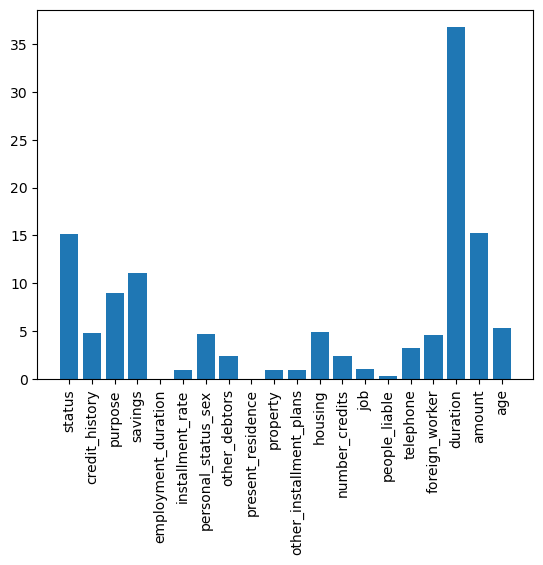

In [16]:
for i in range(len(fs.scores_)):
    print(f"{feature_x.columns[i]}: {fs.scores_[i]:.3f}")
    
# xalların grafiki
plt.bar(feature_x.columns, fs.scores_)
plt.xticks(rotation=90)
plt.show()


Model üçün seçilməli olan featurlar xüsusi tapşırıqdan və datanın xüsusiyyətlərindən asılıdır. Ümumiyyətlə, Anova-nın F dəyəri nə qədər yüksəkdirsə, funksiya hədəf dəyişənini proqnozlaşdırmaq üçün daha vacibdir.

Aldığımız çıxışa baxdıqda, status, savings, duration və amount funksiyalarının ən yüksək ANOVA F-value ballarına sahib olduğu və hədəf dəyişənini proqnozlaşdırmaq üçün ən vacib funksiyalar ola biləcəyi görünür. Bununla birlikdə, funksiyalar arasındakı konteksti və potensial əlaqələri nəzərə almaq və müəyyən bir problemi həll etmək üçün ən yaxşı funksiyaları təyin etmək üçün daha çox analiz və təcrübə aparmaq vacibdir.

# Support Vector Machine

SMOTE

In [25]:
train_x = dataset[['status', 'credit_history', 'purpose', 'savings','personal_status_sex',
              'property', 'housing','job','foreign_worker','duration','amount']]
train_y = dataset[["credit_risk"]]

In [26]:
X_train,X_test,y_train,y_test =train_test_split(train_x,train_y,test_size=0.3,random_state=42)

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [28]:
X_train_smote,y_train_smote = smote.fit_resample(train_x,train_y)

In [29]:
print("Before SMOTE: ", train_y["credit_risk"].value_counts())

Before SMOTE:  1    700
0    300
Name: credit_risk, dtype: int64


In [30]:
print("After SMOTE: ", y_train_smote["credit_risk"].value_counts())

After SMOTE:  1    700
0    700
Name: credit_risk, dtype: int64


In [31]:
svclassifier = SVC(kernel="poly",degree=10)
svclassifier.fit(X_train_smote,np.ravel(y_train_smote))

SVC(degree=10, kernel='poly')

In [32]:
yhat_svm = svclassifier.predict(X_test)
print(classification_report(y_test, yhat_svm))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        92
           1       0.93      0.98      0.95       208

    accuracy                           0.93       300
   macro avg       0.94      0.91      0.92       300
weighted avg       0.93      0.93      0.93       300

